In [1]:
import numpy as no
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Input, Reshape, Conv2D, Conv2DTranspose, MaxPooling2D, LeakyReLU, BatchNormalization
from keras.layers.merge import Concatenate
from keras import Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from google.colab import files

Using TensorFlow backend.


In [0]:
IMAGE_SIZE = (64, 64)
DIM = 3
IMAGE_SIZE_D = (IMAGE_SIZE[0], IMAGE_SIZE[1], DIM)
FIRST_SIZE = 8
NOISE_SIZE = 100

In [3]:
!unzip pokemon_small.zip

Archive:  pokemon_small.zip
replace pokemon_small/1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace pokemon_small/10.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
import os
import cv2
import numpy as np

# read images
images = []
edges = []
noisy_images = []

for filename in os.listdir('pokemon_small'):
    img = cv2.imread('pokemon_small/' + filename)
    img = cv2.resize(img, IMAGE_SIZE, interpolation=cv2.INTER_AREA)
    edge = cv2.Canny(img,100,200)
    img = img / 255
    edge = edge / 255
    noise = np.random.normal(0.0, 0.07, (IMAGE_SIZE[0], IMAGE_SIZE[1], DIM))
    images.append(img)
    edges.append(edge)
    noisy_images.append(img + noise)
images = np.array(images)
noisy_images = np.array(noisy_images)
edges = np.array(edges)
edges = edges.reshape((edges.shape[0], edges.shape[1], edges.shape[2], 1))
print(edges.shape)

(819, 64, 64, 1)


In [0]:
#TODO: use his instead of categorical crossentropy
def wasserstein_loss(yTrue, yPred):
    return K.mean(yTrue * yPred)


In [0]:
def get_generator():
    # conditional input
    inp_c = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
    g_c = Conv2D(64, (5, 5), strides=(2, 2), padding='same')(inp_c)
    g_c = LeakyReLU(alpha=0.2)(g_c)
    g_c = Dropout(0.3)(g_c)

    g_c = Conv2D(16, (5, 5), strides=(2, 2), padding='same')(g_c)
    g_c = LeakyReLU(alpha=0.2)(g_c)
    g_c = Dropout(0.3)(g_c)
    
    g_c = Flatten()(g_c)

    g = Dense(FIRST_SIZE * FIRST_SIZE * DIM, use_bias=False, activation='relu')(g_c)
    g = BatchNormalization()(g)

    # out: (FIRST_SIZE, FIRST_SIZE, DIM)
    g = Reshape((FIRST_SIZE, FIRST_SIZE, DIM))(g)

    # out: (1024, 8, 8)
    g = Conv2DTranspose(1024, (3,3), strides=(1, 1), padding='same', use_bias=False)(g)
    g = BatchNormalization()(g)
    g = LeakyReLU(alpha=0.2)(g)

    # out: (512, 16, 16)
    g = Conv2DTranspose(512, (5,5), strides=(2, 2), padding='same', use_bias=False)(g)
    g = BatchNormalization()(g)
    g = LeakyReLU(alpha=0.2)(g)

    # out: (256, 32, 32)
    g = Conv2DTranspose(257, (5,5), strides=(2, 2), padding='same', use_bias=False)(g)
    g = BatchNormalization()(g)
    g = LeakyReLU(alpha=0.2)(g)

    # out: (128, 64, 64)
    g = Conv2DTranspose(128, (3,3), strides=(2, 2), padding='same', use_bias=False)(g)
    g = BatchNormalization()(g)
    g = LeakyReLU(alpha=0.2)(g)

    g = Conv2D(3, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='sigmoid')(g)

    return Model(inp_c, output=g)

In [0]:
def get_discriminator():
    # conditional
    inp_c = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
    # disc
    inp = Input(IMAGE_SIZE_D)
    d = Concatenate(axis=3)([inp_c, inp])
    d = Conv2D(64, (5, 5), strides=(2, 2), padding='same')(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Dropout(0.3)(d)

    d = Conv2D(128, (5, 5), strides=(2, 2), padding='same')(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Dropout(0.3)(d)

    d = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Dropout(0.3)(d)

    d = Flatten()(d)

    d = Dense(1, activation='sigmoid')(d)

    return Model(inputs=[inp_c, inp], output=d)

In [0]:
def get_adversarial():
    g = get_generator()
    d = get_discriminator()
    d.trainable = True
    d.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
    d.trainable = False
    
    adv_inp_c = Input(shape=[IMAGE_SIZE[0], IMAGE_SIZE[1], 1])
    adv = g(adv_inp_c)
    adv = d([adv_inp_c, adv])
    adv_m = Model(adv_inp_c, output=adv)

    adv_m.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
    
    return g, d, adv_m

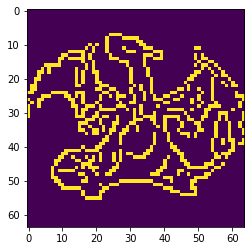

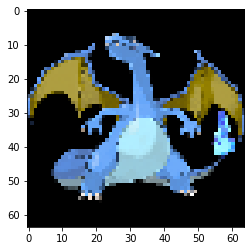

In [9]:
plt.imshow(edges[0].reshape((64,64)))
plt.show()
plt.imshow(images[0].reshape((64,64,3)))

In [0]:
from keras.utils import plot_model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("co...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("mo...)`
  # This is added back by InteractiveShellApp.init_path()


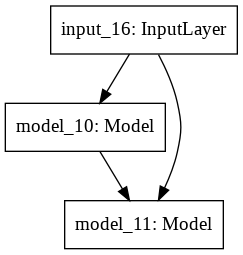

In [17]:
g, d, adv = get_adversarial()
plot_model(adv, to_file="model.png", expand_nested=False)

In [0]:
def get_ranom_images(batch_size):
    idxes = np.random.randint(0, images.shape[0], size=batch_size)
    return (images[idxes, :, :, :], edges[idxes, :, :])

def get_noise_vector(N):
    return np.random.normal(0.0, 1.0, size=[N, NOISE_SIZE])

def show_generated():
    img, cond = get_ranom_images(1)
    fake = g.predict(cond)
    plt.imshow(fake.reshape(IMAGE_SIZE_D))
    print('Discriminator - P(real) = %f' % d.predict([cond, fake]))
    plt.show()

def train_d(batch_size):
    d_real, cond = get_ranom_images(batch_size*2)
    #noise = get_noise_vector(batch_size)
    d_fake = g.predict(cond[:batch_size])

    x = [cond, np.concatenate((d_real[:batch_size], d_fake))]
    y = np.ones([2 * batch_size, 1])
    y[batch_size:, :] = 0

    return d.train_on_batch(x, y)

def train_adv(batch_size):
    y = np.ones([batch_size, 1])
    #noise = get_noise_vector(batch_size)
    _, cond  = get_ranom_images(batch_size)
    return adv.train_on_batch(cond, y)

def train(epochs=30, reuse=False, batch_size=64, modulus=10):
    if not reuse:
        print('(re)initializing model')
        g, d, adv = get_adversarial()

    d_loss = train_d(batch_size)
    g_loss = train_adv(batch_size)

    ds, gs = 0, 0
    for e in range(epochs):
        trained = ''
        if d_loss[1] * 0.9 > g_loss[1]:
            trained = 'Adversarial'
            g_loss = train_adv(batch_size)
            train_d(batch_size)
            gs += 1
        elif d_loss[1] <= 0.9 * g_loss[1]:
            trained = 'Discriminator'
            d_loss = train_d(batch_size)
            train_adv(batch_size)
            ds += 1
        else:
            trained = 'Both'
            d_loss = train_d(batch_size)
            g_loss = train_adv(batch_size)
            gs += 1
            ds += 1

        if e % modulus == 0:
            print('Epoch %d - %s  -  g: %d d: %d' % (e, trained, gs, ds))
            print('Discriminator loss: %f acc: %f' % (d_loss[0], d_loss[1]))
            print('Adversarial loss: %f acc: %f' % (g_loss[0], g_loss[1]))
            show_generated()
            print('-----------------------------')
        if e % 10000 == 0 and e > 1:
            name = 'models/gan_e' + str(e) + '.h5'
            adv.save(name)
    


(re)initializing model


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("co...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("mo...)`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected train

Epoch 0 - Adversarial  -  g: 1 d: 0
Discriminator loss: 0.691056 acc: 0.523438
Adversarial loss: 0.675928 acc: 0.656250
Discriminator - P(real) = 0.497529


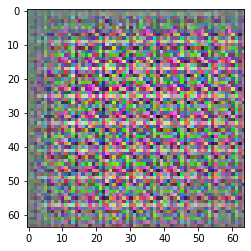

-----------------------------
Epoch 200 - Both  -  g: 148 d: 189
Discriminator loss: 0.004391 acc: 1.000000
Adversarial loss: 0.088813 acc: 1.000000
Discriminator - P(real) = 0.002617


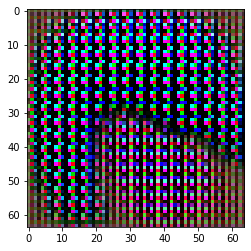

-----------------------------
Epoch 400 - Both  -  g: 348 d: 389
Discriminator loss: 0.093794 acc: 0.960938
Adversarial loss: 0.006045 acc: 1.000000
Discriminator - P(real) = 0.010125


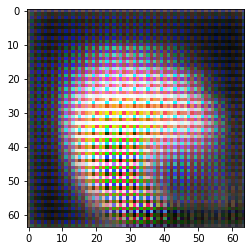

-----------------------------
Epoch 600 - Both  -  g: 526 d: 589
Discriminator loss: 0.008193 acc: 1.000000
Adversarial loss: 0.001336 acc: 1.000000
Discriminator - P(real) = 0.000002


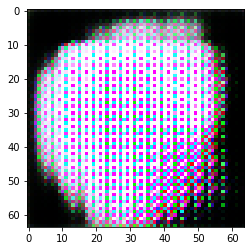

-----------------------------
Epoch 800 - Adversarial  -  g: 719 d: 786
Discriminator loss: 0.066333 acc: 1.000000
Adversarial loss: 0.097245 acc: 1.000000
Discriminator - P(real) = 0.250023


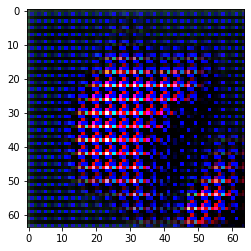

-----------------------------
Epoch 1000 - Both  -  g: 912 d: 979
Discriminator loss: 0.111901 acc: 0.968750
Adversarial loss: 0.092940 acc: 0.984375
Discriminator - P(real) = 0.032361


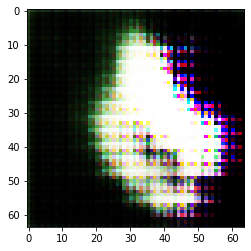

-----------------------------
Epoch 1200 - Both  -  g: 1107 d: 1176
Discriminator loss: 0.013398 acc: 1.000000
Adversarial loss: 0.000062 acc: 1.000000
Discriminator - P(real) = 0.000375


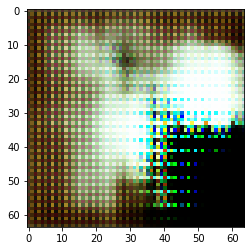

-----------------------------


In [0]:
train(epochs=60000, modulus=200)

In [0]:
show_generated()

In [0]:
adv = keras.models.load_model('models/gan_e10000.h5')

In [0]:
adv.save_weights('models/weights.h5')

In [0]:
weights